##### plot average genotypes in the validation set for each inversion

In [1]:
import allel
from collections import namedtuple
import datetime
import h5py
import ingenos
import itertools
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection
%matplotlib inline

##### set base directory

In [2]:
base = "/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo"

##### read in the data and the splits and subset off the validation set

##### 2R data

In [3]:
v_2R, g_2R = ingenos.import_data(
    "/afs/crc.nd.edu/group/BesanskyNGS2/inversion_genotyping/merged_p2_and_VObs_2R.h5", "2R")

merged_2R = h5py.File(
    "/afs/crc.nd.edu/group/BesanskyNGS2/inversion_genotyping/merged_p2_and_VObs_2R.h5", 
    mode="r")

gq_2R = merged_2R["2R"]['calldata']['GQ'][:]

g_2R.mask = gq_2R < 20

##### 2L data

In [4]:
path_2L = "/afs/crc.nd.edu/group/BesanskyNGS2/inversion_genotyping/merged_p2_and_VObs_2L.h5"
chrom_2L = "2L"

callset_2L = h5py.File(path_2L, mode='r')[chrom_2L]

v_2L = allel.VariantChunkedTable(callset_2L['variants'], index='POS',
                                names=['POS','REF','ALT','DP','MQ','QD','numalt'])

g_2L = allel.GenotypeChunkedArray(callset_2L['calldata']['GT'])

gq_2L = callset_2L['calldata']['GQ'][:]

g_2L.mask = gq_2L < 20

##### metadata

In [5]:
md_2L = pd.read_csv(base + "/metadata/all_samples_2L_metadata_annotated_sites_matching_051019.csv", sep="\t")
md_2R = pd.read_csv(base + "/metadata/all_samples_2R_metadata_annotated_sites_matching_052619.csv", sep="\t")

##### read in original splits

In [6]:
splits = np.load(base + "/metadata/comp_karyo_splits/splits.npy",
                allow_pickle=True).flat[0]

d_splits = np.load(base + "/metadata/comp_karyo_splits/2Rdj_splits.npy",
                  allow_pickle=True).flat[0]

##### subset the genotypes and metadata to correspond to the validation set for each inversion

In [7]:
g_2La = g_2L.subset(sel1 = md_2L["ox_code"].isin(splits["2La"]["test"]).values)
g_2Rj = g_2R.subset(sel1 = md_2R["ox_code"].isin(splits["2Rj"]["test"]).values)
g_2Rb = g_2R.subset(sel1 = md_2R["ox_code"].isin(splits["2Rb"]["test"]).values)
g_2Rc = g_2R.subset(sel1 = md_2R["ox_code"].isin(splits["2Rc"]["test"]).values)
g_2Rd = g_2R.subset(sel1 = md_2R["ox_code"].isin(d_splits["2Rd"]["test"]).values)
g_2Ru = g_2R.subset(sel1 = md_2R["ox_code"].isin(splits["2Ru"]["test"]).values)

In [8]:
md_2La = md_2L.loc[md_2L["ox_code"].isin(splits["2La"]["test"]),:]
md_2Rj = md_2R.loc[md_2R["ox_code"].isin(splits["2Rj"]["test"]),:]
md_2Rb = md_2R.loc[md_2R["ox_code"].isin(splits["2Rb"]["test"]),:]
md_2Rc = md_2R.loc[md_2R["ox_code"].isin(splits["2Rc"]["test"]),:]
md_2Rd = md_2R.loc[md_2R["ox_code"].isin(d_splits["2Rd"]["test"]),:]
md_2Ru = md_2R.loc[md_2R["ox_code"].isin(splits["2Ru"]["test"]),:]

##### subset 2Rc further by species, excluding Bamako from gambiae ss. In these specimens, the Bamako are the only 2Rj inverted homokaryotypes, so we can remove them on that basis. However, Bamako is formally defined as an An. gambiae inverted homokaryotype for three inversions, 2Rj, 2Rc, and 2Ru

In [9]:
g_2Rc_col = g_2Rc.subset(sel1 = md_2Rc["species"] == "An. coluzzii")
g_2Rc_gam = g_2Rc.subset(sel1 = ((md_2Rc["species"] == "An. gambiae") &\
                         (md_2Rc["2Rj"] != "2.0")))

In [10]:
md_2Rc_col = md_2Rc.loc[md_2Rc["species"] == "An. coluzzii",:]
md_2Rc_gam = md_2Rc.loc[((md_2Rc["species"] == "An. gambiae") &\
                         (md_2Rc["2Rj"] != "2.0")),:]

##### make sure the shapes of genotypes and metadata match

In [11]:
md_2La.shape

(337, 30)

In [12]:
md_2La.shape[0] == g_2La.shape[1]

True

In [13]:
md_2Rj.shape

(195, 61)

In [14]:
md_2Rj.shape[0] == g_2Rj.shape[1]

True

In [15]:
md_2Rb.shape

(325, 61)

In [16]:
md_2Rb.shape[0] == g_2Rb.shape[1]

True

In [17]:
md_2Rc_col.shape

(80, 61)

In [18]:
md_2Rc_col.shape[0] == g_2Rc_col.shape[1]

True

In [19]:
md_2Rc_gam.shape

(196, 61)

In [20]:
md_2Rc_gam.shape[0] == g_2Rc_gam.shape[1]

True

In [21]:
md_2Rd.shape

(201, 61)

In [22]:
md_2Rd.shape[0] == g_2Rd.shape[1]

True

In [23]:
md_2Ru.shape

(286, 61)

In [24]:
md_2Ru.shape[0] == g_2Ru.shape[1]

True

##### read in the top SNPs

In [25]:
a_top = pd.read_csv(base + "/data/results/2La/comp/predictive_SNPs_train_set_0995_110918.tsv",
               sep = "\t", header=None)

j_top = pd.read_csv(base + "/data/results/2Rj/comp/predictive_SNPs_train_set_08_110918.tsv",
               sep = "\t", header=None)

b_top = pd.read_csv(base + "/data/results/2Rb/comp/predictive_SNPs_train_set_08_110918.tsv",
               sep = "\t", header=None)

u_top = pd.read_csv(base + "/data/results/2Ru/comp/predictive_SNPs_train_set_08_110918.tsv",
               sep = "\t", header=None)

d_top = pd.read_csv(base + "/data/results/2Rd/comp/predictive_SNPs_train_set_08_052619.tsv",
               sep = "\t", header=None)

c_col_top = pd.read_csv(
    base + "/data/results/2Rc/comp/col_predictive_SNPs_train_set_08_031919.tsv", sep="\t", 
    header=None)

c_gam_top = pd.read_csv(
    base + "/data/results/2Rc/comp/gam_ss_predictive_SNPs_train_set_08_031919.tsv",
            sep="\t", header=None)

##### define the Inversion namedtuple object to organize the inversions to be queried

In [26]:
Inversion = namedtuple('Inversion',['SNPs','metadata','genotypes','inv_title'])

In [27]:
inv_dict = {"2La" : Inversion(SNPs = a_top.values, metadata = md_2La, genotypes = g_2La,
                             inv_title = "new_PCA_2La"),
            "2Rj" : Inversion(SNPs = j_top.values, metadata = md_2Rj, genotypes = g_2Rj,
                            inv_title = "new_PCA_2Rj"),
           "2Rb" : Inversion(SNPs = b_top.values, metadata = md_2Rb, genotypes = g_2Rb,
                            inv_title = "new_PCA_2Rb"),
            "2Rc_col" : Inversion(SNPs = c_col_top.values, metadata = md_2Rc_col, 
                                  genotypes = g_2Rc_col,
                            inv_title = "new_PCA_2Rc"),
            "2Rc_gam" : Inversion(SNPs = c_gam_top.values, metadata = md_2Rc_gam, 
                                  genotypes = g_2Rc_gam,
                            inv_title = "new_PCA_2Rc"),
           "2Rd" : Inversion(SNPs = d_top[0].values, metadata = md_2Rd, genotypes = g_2Rd,
                            inv_title = "new_PCA_2Rd"),
           "2Ru" : Inversion(SNPs = u_top.values, metadata = md_2Ru, genotypes = g_2Ru,
                            inv_title = "new_PCA_2Ru")}

In [28]:
average_dict = {inversion : None for inversion in inv_dict.keys()}
average_dict

{'2La': None,
 '2Rj': None,
 '2Rb': None,
 '2Rc_col': None,
 '2Rc_gam': None,
 '2Rd': None,
 '2Ru': None}

In [29]:
for inversion in inv_dict.keys():
    
    ##set up objects
    SNPs = inv_dict[inversion].SNPs
    md = inv_dict[inversion].metadata
    gt = inv_dict[inversion].genotypes[:]
    col_name = inv_dict[inversion].inv_title
    new_col_name = inversion + "_assigned"
    mean_name = inversion + "_means"
    
    if inversion == "2La":
        
        vt = v_2L[:]
        
    else:
        
        vt = v_2R[:]
    
    ##identify sites found in the data
    site_indices = []
    
    for site in SNPs:
    
        where = np.where(vt["POS"] == site)
        
        if len(where[0]) > 0:
                
            site_indices.append(where[0][0])
            
    print(inversion, "# targets: ", str(len(SNPs)), " # found: ", str(len(site_indices)))
    
    ##identify biallelic sites
    
    bi_bool = gt.subset(sel0 = site_indices).count_alleles().max_allele() <= 1
        
    alts = gt.subset(sel0 = site_indices).subset(sel0 = bi_bool).to_n_alt()
        
    is_called = gt.subset(sel0 = site_indices).subset(sel0 = bi_bool).is_called()
    
    av_gts = np.mean(np.ma.MaskedArray(
            alts, mask = ~is_called), axis=0).data
            
    total_sites = np.sum(is_called, axis=0)
        
    karyos = []
    
    for alt in av_gts:
        
        if alt <= (2/3):
            
            karyos.append(0)
            
        elif alt > (2/3) and alt <= (4/3):
            
            karyos.append(1)
            
        else:
            
            karyos.append(2)
            
    md[new_col_name] = karyos
    md[mean_name] = av_gts
    
    mismatches = np.sum(md[new_col_name] != md[col_name].map(float).map(int))

    average_dict[inversion] = (len(site_indices), av_gts)

    print(inversion, " # mismatches: ", mismatches,"\n")
    #print(av_gts)
    #print(total_sites,"\n")

2La # targets:  209  # found:  209
2La  # mismatches:  0 



/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2Rj # targets:  99  # found:  99
2Rj  # mismatches:  0 

2Rb # targets:  349  # found:  349
2Rb  # mismatches:  0 

2Rc_col # targets:  57  # found:  57
2Rc_col  # mismatches:  0 

2Rc_gam # targets:  49  # found:  49
2Rc_gam  # mismatches:  1 

2Rd # targets:  147  # found:  147
2Rd  # mismatches:  0 

2Ru # targets:  177  # found:  177
2Ru  # mismatches:  0 



##### plot

In [30]:
inversion_list = ["2La","2Rj","2Rb","2Rc_col","2Rc_gam","2Rd","2Ru"]
inversion_title_list = ["2La","2Rj","2Rb","2Rc coluzzii","2Rc gambiae","2Rd","2Ru"]

''

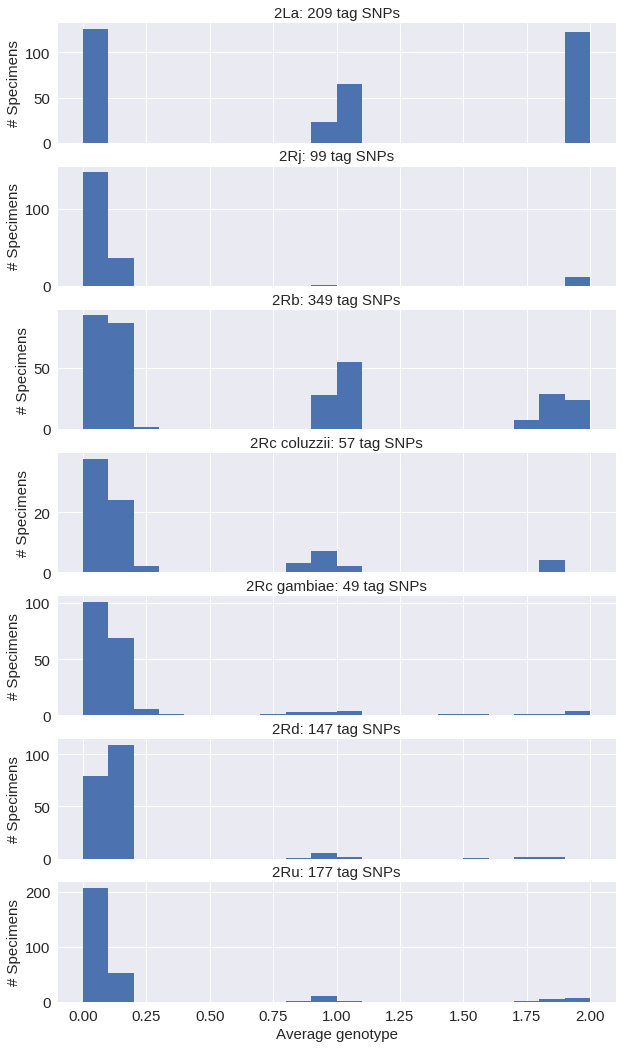

In [31]:
outString = ingenos.make_date_stamp(
    base + "/data/results/comp_aim1/validation_set_average_genotypes")

fig, axes = plt.subplots(nrows=7, ncols=1, sharex=True, figsize = (10, 18))

for i, ax in enumerate(axes):
    
    inversion = inversion_list[i]
    
    name = inversion_title_list[i]
        
    num_sites = average_dict[inversion][0]
    
    alts = average_dict[inversion][1]
    
    #fig, ax = plt.subplots(figsize = (10, 3))
    ax.hist(alts, range=(0,2), bins=20)
    ax.locator_params(axis="y", integer=True)
       
    if i == 6:
        ax.set_xlabel("Average genotype", fontsize=15)
        
    ax.set_ylabel("# Specimens", fontsize=15)
    ax.tick_params(labelsize=15)
    #ax.set_xlim(0,2)
    ax.set_title("{inversion}: {num} tag SNPs".format(inversion = name,
                                                              num = num_sites), fontsize=15)
    
;
plt.savefig(outString);